# Different LSTM gate - tanh, relu and sin

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

### Data loading

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Hyperparameters

In [3]:
l_r = 0.01 # Learning rate
epoch = 2000
batch_size = 128

In [4]:
n_inputs = 28 # MNIST data input, img shape = (28, 28), view the graph row by row
n_steps = 28 # Time steps - shift 28 times
n_hidden_units = 128 # Neuron no. in hidden layer
n_classes = 10 # 0~9

### Placeholder - input and output data holders

In [5]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

### Create static initial parameters

In [6]:
# create static initial parameters
w_h1 = tf.random_normal([n_inputs, n_hidden_units])
w_out = tf.random_normal([n_hidden_units, n_classes])
b_h1 = tf.random_normal([n_hidden_units, ])
b_out = tf.random_normal([n_classes, ])

In [7]:
def get_static_w_b():
    # create static initial parameters
    w_h1 = tf.random_normal([n_inputs, n_hidden_units])
    w_out = tf.random_normal([n_hidden_units, n_classes])
    b_h1 = tf.random_normal([n_hidden_units, ])
    b_out = tf.random_normal([n_classes, ])
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        w_h1, w_out, b_h1, b_out = sess.run([w_h1, w_out, b_h1, b_out])
    weights = dict()
    biases = dict()
    weights['sig'] = {
        # (28 inputs, 128 neurons)
        'h1':tf.Variable(tf.constant(w_h1)),
        # (128 inputs, 10 neurons)
        'out':tf.Variable(tf.constant(w_out))
    }
    biases['sig'] = {
        # (128 neurons, )
        'h1':tf.Variable(tf.constant(b_h1)),
        # (10 neurons, )
        'out':tf.Variable(tf.constant(b_out))
    }
    weights['relu'] = {
        # (28 inputs, 128 neurons)
        'h1':tf.Variable(tf.constant(w_h1)),
        # (128 inputs, 10 neurons)
        'out':tf.Variable(tf.constant(w_out))
    }
    biases['relu'] = {
        # (128 neurons, )
        'h1':tf.Variable(tf.constant(b_h1)),
        # (10 neurons, )
        'out':tf.Variable(tf.constant(b_out))
    }
    weights['tanh'] = {
        # (28 inputs, 128 neurons)
        'h1':tf.Variable(tf.constant(w_h1)),
        # (128 inputs, 10 neurons)
        'out':tf.Variable(tf.constant(w_out))
    }
    biases['tanh'] = {
        # (128 neurons, )
        'h1':tf.Variable(tf.constant(b_h1)),
        # (10 neurons, )
        'out':tf.Variable(tf.constant(b_out))
    }
    return weights, biases

### RNN structure

In [8]:
def RNN(X, weights, biases, gate='sig'):
    # h1
    X = tf.reshape(X, [-1, n_inputs])
    X_in = tf.matmul(X, weights[gate]['h1']) + biases[gate]['h1']
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])
    if gate == 'sig':
        g = tf.sigmoid
    elif gate == 'relu':
        g = tf.nn.relu
    elif gate == 'tanh':
        g = tf.tanh
    with tf.variable_scope(gate):
        # rnn cell
        rnn_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units,
                                                              forget_bias=1.0,
                                                              state_is_tuple=True,
                                                              activation=g)
        _init_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
        # outputs: the rnns outputs
        outputs, states = tf.nn.dynamic_rnn(cell=rnn_cell,
                                            inputs=X_in,
                                            initial_state=_init_state,
                                            time_major=False,)
    
    # output layer
    outputs = tf.unstack(tf.transpose(outputs, [1, 0, 2]))
    results = tf.matmul(outputs[-1], weights[gate]['out']) + biases[gate]['out']
    
    return results

In [9]:
def get_pred(x, weights, biases):
    pred = dict()
    pred['sig'] = RNN(x, weights, biases, gate='sig')
    pred['relu'] = RNN(x, weights, biases, gate='relu')
    pred['tanh'] = RNN(x, weights, biases, gate='tanh')
    return pred

def get_loss(pred, y):
    loss = dict()
    loss['sig'] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred['sig'], labels=y))
    loss['relu'] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred['relu'], labels=y))
    loss['tanh'] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred['tanh'], labels=y))
    return loss

def get_op(loss, l_r):
    train_op = dict()
    train_op['sig'] = tf.train.GradientDescentOptimizer(l_r).minimize(loss['sig'])
    train_op['relu'] = tf.train.GradientDescentOptimizer(l_r).minimize(loss['relu'])
    train_op['tanh'] = tf.train.GradientDescentOptimizer(l_r).minimize(loss['tanh'])
    return train_op

In [10]:
ex_time = 0

### Experiments

In [11]:
import time
test_batch_size = batch_size
loss_val_train = dict()
loss_val_test = dict()
loss_val_train['sig'] = list()
loss_val_train['relu'] = list()
loss_val_train['tanh'] = list()
loss_val_test['sig'] = list()
loss_val_test['relu'] = list()
loss_val_test['tanh'] = list()
for ex in range(10):
    ex_time += 1
    with tf.variable_scope('ex'+str(ex_time)):
        weights, biases = get_static_w_b()
        pred = get_pred(x, weights, biases)
        loss = get_loss(pred, y)
        train_op = get_op(loss, l_r)
    init2 = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init2)
        startTime = time.time()
        for epo in range(epoch):
            # read data
            batch_xs_train, batch_ys_train = mnist.train.next_batch(batch_size)
            batch_xs_train = batch_xs_train.reshape([batch_size, n_steps, n_inputs])
            # Training
            sess.run([train_op['sig'], train_op['relu'], train_op['tanh']], feed_dict={
                x:batch_xs_train,
                y:batch_ys_train
            })
            # find loss for training set
            l_sig, l_relu, l_tanh = sess.run([loss['sig'], loss['relu'], loss['tanh']], 
                                                    feed_dict={
                                                        x:batch_xs_train,
                                                        y:batch_ys_train
                                                    })
            loss_val_train['sig'].append(l_sig)
            loss_val_train['relu'].append(l_relu)
            loss_val_train['tanh'].append(l_tanh)
            # read test data
            batch_xs_test, batch_ys_test = mnist.test.next_batch(batch_size)
            batch_xs_test = batch_xs_test.reshape([test_batch_size, n_steps, n_inputs])
            # find loss for testing set
            l_sig, l_relu, l_tanh = sess.run([loss['sig'], loss['relu'], loss['tanh']], 
                                                    feed_dict={
                                                        x:batch_xs_test,
                                                        y:batch_ys_test
                                                    })
            loss_val_test['sig'].append(l_sig)
            loss_val_test['relu'].append(l_relu)
            loss_val_test['tanh'].append(l_tanh)
            # print result each 100 epochs
            if (epo+1)%100 == 0:
                print('Epoch', epo+1,
                      ', Losses:', '%2.4f, %2.4f, %2.4f' % (l_sig, l_relu, l_tanh))
        endTime = time.time()
        timespan = endTime - startTime
        print('--------------------EX'+str(ex+1), 'done.', 'Spent', '%2.2f' % timespan, 'secs.')
        writer = tf.summary.FileWriter("logs/", sess.graph)
# tensorboard: terminal >> tensorboard --logdir='logs/'

Epoch 100 , Losses: 2.0517, nan, 1.4053
Epoch 200 , Losses: 1.8418, nan, 0.9597
Epoch 300 , Losses: 1.7206, nan, 0.6212
Epoch 400 , Losses: 1.6056, nan, 0.7672
Epoch 500 , Losses: 1.5121, nan, 0.5979
Epoch 600 , Losses: 1.5712, nan, 0.6866
Epoch 700 , Losses: 1.4143, nan, 0.4019
Epoch 800 , Losses: 1.1934, nan, 0.3292
Epoch 900 , Losses: 1.1392, nan, 0.4408
Epoch 1000 , Losses: 1.1512, nan, 0.4969
Epoch 1100 , Losses: 1.1659, nan, 0.4627
Epoch 1200 , Losses: 1.0643, nan, 0.4667
Epoch 1300 , Losses: 1.0923, nan, 0.4110
Epoch 1400 , Losses: 1.0774, nan, 0.4499
Epoch 1500 , Losses: 0.9577, nan, 0.2552
Epoch 1600 , Losses: 0.8055, nan, 0.2498
Epoch 1700 , Losses: 0.8152, nan, 0.3047
Epoch 1800 , Losses: 0.9007, nan, 0.4039
Epoch 1900 , Losses: 0.8188, nan, 0.3520
Epoch 2000 , Losses: 0.8661, nan, 0.2440
--------------------EX1 done. Spent 100.09 secs.
Epoch 100 , Losses: 2.0863, nan, 1.4535
Epoch 200 , Losses: 1.8530, nan, 0.9978
Epoch 300 , Losses: 1.6653, nan, 0.6759
Epoch 400 , Losses: 

Epoch 1300 , Losses: 1.1712, nan, 0.4497
Epoch 1400 , Losses: 0.9572, nan, 0.3477
Epoch 1500 , Losses: 0.7531, nan, 0.2100
Epoch 1600 , Losses: 0.8692, nan, 0.3137
Epoch 1700 , Losses: 0.8877, nan, 0.2637
Epoch 1800 , Losses: 0.9278, nan, 0.4693
Epoch 1900 , Losses: 0.9352, nan, 0.2522
Epoch 2000 , Losses: 0.8831, nan, 0.3143
--------------------EX10 done. Spent 100.57 secs.


In [12]:
#save the result
np.save('./diffGate_data/loss_val_train_diffGate', loss_val_train)
np.save('./diffGate_data/loss_val_test_diffGate', loss_val_test)

### Result

In [16]:
epoch = 2000
import numpy as np
loss_val_train = np.load('./diffGate_data/loss_val_train_diffGate.npy')
loss_val_test = np.load('./diffGate_data/loss_val_test_diffGate.npy')
loss_val_train = loss_val_train[None][0]
loss_val_test = loss_val_test[None][0]

In [17]:
# result ploting
import matplotlib.pyplot as plt

### Epoch - Training loss & accuracy

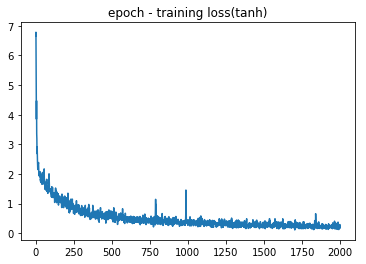

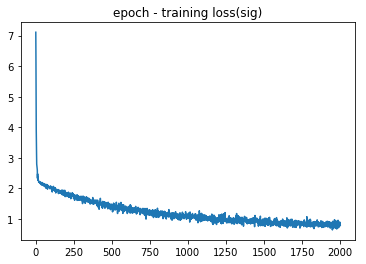

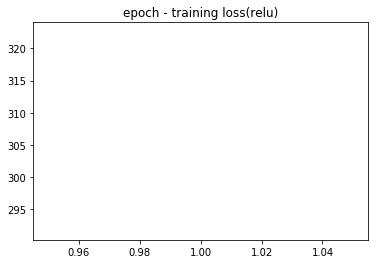

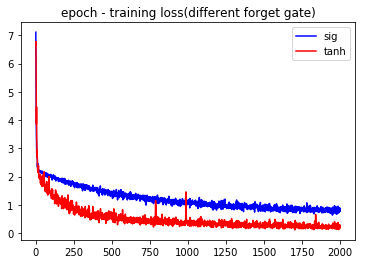

In [18]:
# epoch v.s.training loss
i = 0
for gate, losses in loss_val_train.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+gate+')')
    plt.show()
    i += 1
plt.plot(range(1, len(loss_val_train['sig'][-epoch:])+1), loss_val_train['sig'][-epoch:], 'b',
         range(1, len(loss_val_train['tanh'][-epoch:])+1), loss_val_train['tanh'][-epoch:], 'r')
plt.title('epoch - training loss(different forget gate)')
plt.legend(['sig', 'tanh'], loc=1)
plt.show()

### Epoch - Testing loss & accuracy

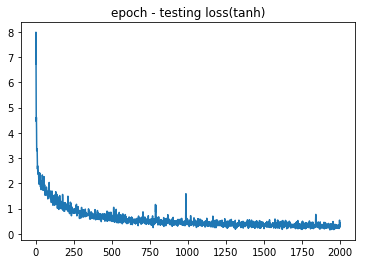

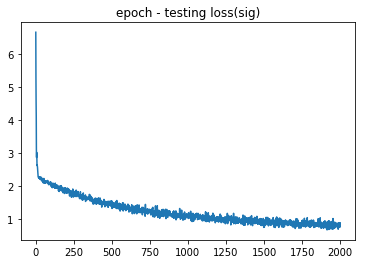

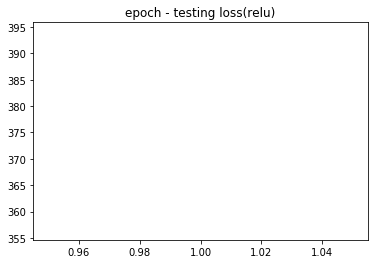

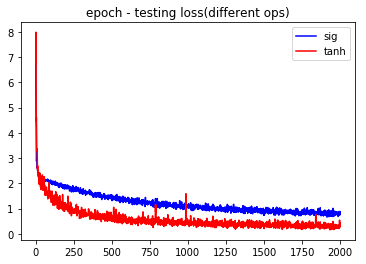

In [19]:
# epoch v.s. testing loss
i = 0
for gate, losses in loss_val_test.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - testing loss('+gate+')')
    plt.show()
    i += 1
plt.plot(range(1, len(loss_val_test['sig'][-epoch:])+1), loss_val_test['sig'][-epoch:], 'b',
         range(1, len(loss_val_test['tanh'][-epoch:])+1), loss_val_test['tanh'][-epoch:], 'r')
plt.title('epoch - testing loss(different ops)')
plt.legend(['sig', 'tanh'], loc=1)

plt.show()

In [20]:
# smooth the line
len(loss_val_train['sig'])
last_point = 0
loss_val_train_ = dict()
loss_val_test_ = dict()
# training loss
loss_val_train_['sig'] = list()
loss_list = loss_val_train['sig'][-epoch:]
for i in range(int(len(loss_list)/10)):
    loss_val_train_['sig'].append(np.mean(loss_list[i*10:i*10+10]))
    last_point = i*10+10
if len(loss_list)%10 != 0:
    loss_val_train_['sig'].append(np.mean(loss_list[last_point:]))

loss_val_train_['tanh'] = list()
loss_list = loss_val_train['tanh'][-epoch:]
for i in range(int(len(loss_list)/10)):
    loss_val_train_['tanh'].append(np.mean(loss_list[i*10:i*10+10]))
    last_point = i*10+10
if len(loss_list)%10 != 0:
    loss_val_train_['tanh'].append(np.mean(loss_list[last_point:]))

# testing loss
loss_val_test_['sig'] = list()
loss_list = loss_val_test['sig'][-epoch:]
for i in range(int(len(loss_list)/10)):
    loss_val_test_['sig'].append(np.mean(loss_list[i*10:i*10+10]))
    last_point = i*10+10
if len(loss_list)%10 != 0:
    loss_val_test_['sig'].append(np.mean(loss_list[last_point:]))

loss_val_test_['tanh'] = list()
loss_list = loss_val_test['tanh'][-epoch:]
for i in range(int(len(loss_list)/10)):
    loss_val_test_['tanh'].append(np.mean(loss_list[i*10:i*10+10]))
    last_point = i*10+10
if len(loss_list)%10 != 0:
    loss_val_test_['tanh'].append(np.mean(loss_list[last_point:]))


### Epoch - Training loss & accuracy (smooth)

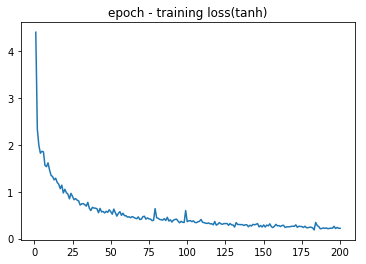

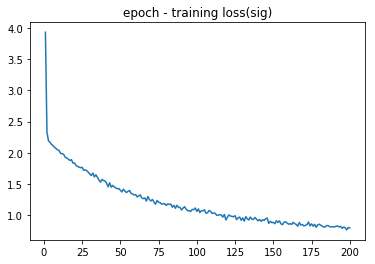

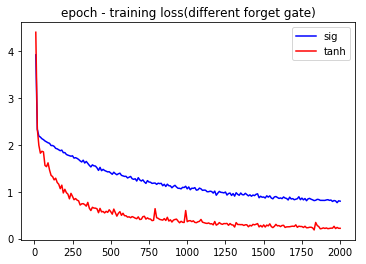

In [22]:
# epoch v.s.training loss - smooth
i = 0
for gate, losses in loss_val_train_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+gate+')')
    plt.show()
    i += 1
plt.plot(range(10, len(loss_val_train_['sig'][-epoch:])*10+10, 10), loss_val_train_['sig'][-epoch:], 'b',
         range(10, len(loss_val_train_['tanh'][-epoch:])*10+10, 10), loss_val_train_['tanh'][-epoch:], 'r')
plt.title('epoch - training loss(different forget gate)')
plt.legend(['sig', 'tanh'], loc=1)
plt.savefig('./diffGate_data/epoch_loss_train.png')
plt.show()

### Epoch - Testing loss & accuracy (smooth)

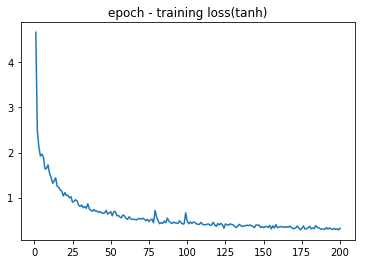

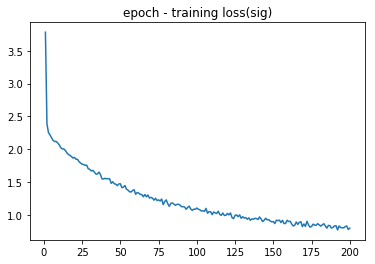

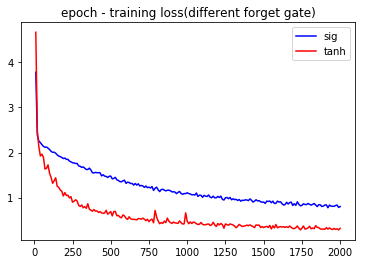

In [23]:
# epoch v.s.training loss - smooth
i = 0
for gate, losses in loss_val_test_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+gate+')')
    plt.show()
    i += 1
plt.plot(range(10, len(loss_val_test_['sig'][-epoch:])*10+10, 10), loss_val_test_['sig'][-epoch:], 'b',
         range(10, len(loss_val_test_['tanh'][-epoch:])*10+10, 10), loss_val_test_['tanh'][-epoch:], 'r')
plt.title('epoch - training loss(different forget gate)')
plt.legend(['sig', 'tanh'], loc=1)
plt.savefig('./diffGate_data/epoch_loss_test.png')
plt.show()

# Statistics Inference : ANOVA and T-test

In [24]:
from scipy import stats as st
# ANOVA:  f_val, p_val = st.f_oneway(data_array1, data_array2, ...)

In [25]:
# data extract
loss_means_train = dict()
for gate, losses in loss_val_train.items():
    mean = list()
    ex_time = len(losses)/epoch
    print(gate, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_train[gate] = mean

loss_means_test = dict()
for gate, losses in loss_val_test.items():
    mean = list()
    ex_time = len(losses)/epoch
    
    print(gate, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_test[gate] = mean

tanh 10.0
sig 10.0
relu 10.0
tanh 10.0
sig 10.0
relu 10.0


In [26]:
np.save('./diffGate_data/loss_means_train_diffGate', loss_means_train)
np.save('./diffGate_data/loss_means_test_diffGate', loss_means_test)
loss_means_train, loss_means_test

({'relu': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'sig': [0.85316658,
   0.82118857,
   0.77812105,
   0.79777092,
   0.79771125,
   0.71572989,
   0.79568434,
   0.72014707,
   0.79123992,
   0.80841631],
  'tanh': [0.20160088,
   0.2169722,
   0.20896669,
   0.194426,
   0.20717396,
   0.20706421,
   0.2069661,
   0.19954455,
   0.19730411,
   0.22546995]},
 {'relu': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'sig': [0.85289228,
   0.84477097,
   0.77882379,
   0.80517626,
   0.80820256,
   0.71832746,
   0.80829155,
   0.73710459,
   0.79710352,
   0.81224751],
  'tanh': [0.27552906,
   0.3041459,
   0.27824098,
   0.27768609,
   0.30402827,
   0.30782163,
   0.29815841,
   0.28373203,
   0.28635752,
   0.30881497]})

In [30]:
# sort them by means
mean = dict()
StD = dict()
for gate, mu in loss_means_train.items():
    mean[gate] = np.mean(mu)
    StD[gate] = np.std(mu)
mus_sort = sorted(mean.values())
gs_sort = sorted(mean, key=mean.__getitem__)
print('Training loss')
print('     bias    mean     StD    ')
for i in range(len(gs_sort)):
    print('%8s    %2.4f   %2.4f' % (gs_sort[i], mus_sort[i], StD[gs_sort[i]]))

Training loss
     bias    mean     StD    
    tanh    0.2065   0.0088
     sig    0.7879   0.0399
    relu    nan   nan


In [29]:
# sort them by means
mean = dict()
StD = dict()
for gate, mu in loss_means_test.items():
    mean[gate] = np.mean(mu)
    StD[gate] = np.std(mu)
mus_sort = sorted(mean.values())
gs_sort = sorted(mean, key=mean.__getitem__)
print('Testing loss')
print('     bias    mean     StD    ')
for i in range(len(gs_sort)):
    print('%8s    %2.4f   %2.4f' % (gs_sort[i], mus_sort[i], StD[gs_sort[i]]))

Testing loss
     bias    mean     StD    
    tanh    0.2925   0.0128
     sig    0.7963   0.0401
    relu    nan   nan


### training loss

In [25]:
# t-test
alpha = 0.05
t_val, p_val = st.ttest_ind(loss_means_train['sig'], loss_means_train['tanh'], equal_var=False)
print('t value:', t_val, ', P value:', p_val)
if p_val <= alpha:
    print('sigmoid loss' + ' > ' + 'tanh loss')
else:
    print('sigmoid loss' + ' = ' + 'tanh loss')

t value: 20.3750610211 , P value: 3.42875364715e-05
sigmoid loss > tanh loss


### testing loss

In [27]:
# t-test
alpha = 0.05
t_val, p_val = st.ttest_ind(loss_means_test['sig'], loss_means_test['tanh'], equal_var=False)
print('t value:', t_val, ', P value:', p_val)
if p_val <= alpha:
    print('sigmoid loss' + ' > ' + 'tanh loss')
else:
    print('sigmoid loss' + ' = ' + 'tanh loss')

t value: 18.0884375964 , P value: 6.70739332854e-05
sigmoid loss > tanh loss
